# Step 1: Data Loading and Initial Cleaning

In [4]:
# Load necessary libraries
library(readr)
library(dplyr)

# Load and clean the dataset
file_path <- "C:\\Users\\User\\juypter\\files\\cardata.csv"
dataset <- read_csv(file_path)

# Remove the "Car_Name" column
dataset <- dataset[, !names(dataset) %in% c("Car_Name")]

# Transform the "Transmission" variable (Automatic=1, Manual=0)
dataset <- dataset %>%
mutate(Transmission = ifelse(Transmission == "Automatic", 1, 0))

# Transform the "Seller_Type" variable (Dealer=1, Individual=0)
dataset <- dataset %>%
mutate(Seller_Type = ifelse(Seller_Type == "Dealer", 1, 0))

# One-hot encode the "Fuel_Type" variable ("Petrol", "Diesel", "CNG")
dataset <- dataset %>%
mutate(Fuel_Type_Petrol = ifelse(Fuel_Type == "Petrol", 1, 0),
Fuel_Type_Diesel = ifelse(Fuel_Type == "Diesel", 1, 0),
Fuel_Type_CNG = ifelse(Fuel_Type == "CNG", 1, 0))

# Drop the original "Fuel_Type" column as it is now one-hot encoded
dataset <- dataset[, !names(dataset) %in% c("Fuel_Type")]

# View summary of the cleaned dataset
summary(dataset)
head(dataset)


ERROR: Error in library(readr): there is no package called 'readr'


# Step 2: Exploratory Data Analysis (EDA)

In [ ]:
# Load necessary libraries for EDA
library(ggplot2)

# Number of bins for histograms
num_bins <- 100  # You can adjust this as needed

# Set up a 3x3 grid layout
par(mfrow=c(3, 3))

# Plot histogram for "Selling_Price"
hist(dataset$Selling_Price,breaks=num_bins,main="Histogram of Selling Price",xlab="Selling Price", col="blue", border="black") # nolint

# Box plots to understand distribution by categorical variables
boxplot(Selling_Price~Year,data=dataset,main="Selling Price by Year",xlab="Year",ylab="Selling Price",col="green")
boxplot(Selling_Price ~Transmission, data=dataset, main="Selling Price by Transmission", xlab="Transmission", ylab="Selling Price", col="green")
boxplot(Selling_Price ~ Owner, data=dataset, main="Selling Price by Owner", xlab="Owner", ylab="Selling Price", col="green") # nolint: infix_spaces_linter.
boxplot(Selling_Price ~ Fuel_Type_Petrol, data=dataset,main="Selling Price by Fuel_Type_Petrol",xlab="Fuel_Type_Petrol", ylab="Selling Price", col="green")
boxplot(Selling_Price ~ Fuel_Type_Diesel, data=dataset, main="Selling Price by Fuel_Type_Diesel", xlab="Fuel_Type_Diesel", ylab="Selling Price", col="green")
boxplot(Selling_Price ~ Fuel_Type_CNG, data=dataset, main="Selling Price by Fuel_Type_CNG", xlab="Fuel_Type_CNG", ylab="Selling Price", col="green")
boxplot(Selling_Price ~Seller_Type,data=dataset,main="Selling Price by Seller_Type",xlab="Seller_Type",ylab="Selling Price", col="green")

# Pair plot to visualize relationships between numeric variables
pairs(selected_vars, main="Selling Price vs Other Variables")

# Reset to default single plot layout
par(mfrow=c(1, 1))


ERROR: Error in pairs.default(selected_vars, main = "Selling Price vs Other Variables"): non-numeric argument to 'pairs'


# Step 3: Splitting Data into Training and Validation Sets

In [ ]:
# Split data into training and validation sets (80/20 split)
set.seed(123)
train_indices <- sample(1:nrow(dataset), size = 0.8 * nrow(dataset))
train_data <- dataset[train_indices, ]
test_data <- dataset[-train_indices, ]

# Verify the split
print(dim(train_data))
print(dim(test_data))


[1] 240  10
[1] 61 10


# Step 4: Model Fitting and Multicollinearity Check

In [ ]:
library(MASS)
library(car)
library(ggplot2)

full_model <- lm(Selling_Price ~ ., data = train_data)

# Step 4: Calculate VIF, excluding one-hot encoded variables
# Identify the one-hot encoded variables to exclude
exclude_vars <- c("Fuel_Type_Petrol", "Fuel_Type_Diesel", "Fuel_Type_CNG")

# Subset the model's coefficients to include only relevant predictors for VIF
vif_model <- lm(Selling_Price ~ . - Fuel_Type_Petrol - Fuel_Type_Diesel - Fuel_Type_CNG, data = train_data)
vif_values <- vif(vif_model)

# Step 5: Create a bar plot for VIF values
vif_data <- data.frame(Variable = names(vif_values), VIF = vif_values)

ggplot(vif_data, aes(x = reorder(Variable, VIF), y = VIF)) +
  geom_bar(stat = "identity", fill = "blue") +
  coord_flip() +
  geom_hline(yintercept = 5, linetype = "dashed", color = "red") +
  labs(title = "VIF Values for Predictor Variables", x = "Variables", y = "VIF") +
  theme_minimal()


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




ERROR: Error in library(car): there is no package called 'car'


# Step 5: Model Selection Using Various Criteria

In [ ]:
library(MASS)
library(leaps)

# Step 2: Model selection using regsubsets
regfit <- regsubsets(Selling_Price ~ ., data = train_data, nvmax = NULL, method = "exhaustive")
regfit_summary <- summary(regfit)

# Best model based on Adjusted R^2
best_index_adj_r2 <- which.max(regfit_summary$adjr2)
model_best_AR <- lm(as.formula(paste("Selling_Price ~", paste(names(coef(regfit, best_index_adj_r2))[-1], collapse = " + "))), data = train_data)
print(summary(model_best_AR))
print("Chosen variables for the best Adjusted R^2 model:")
print(names(coef(model_best_AR))[-1])
print(paste("Number of variables used:", length(names(coef(model_best_AR))[-1])))

# Best model based on Mallows' Cp
best_index_cp <- which.min(regfit_summary$cp)
model_best_Cp <- lm(as.formula(paste("Selling_Price ~", paste(names(coef(regfit, best_index_cp))[-1], collapse = " + "))), data = train_data)
print(summary(model_best_Cp))
print("Chosen variables for the best Mallows' Cp model:")
print(names(coef(model_best_Cp))[-1])
print(paste("Number of variables used:", length(names(coef(model_best_Cp))[-1])))

# Best model based on AIC using stepAIC
model_best_AIC <- stepAIC(lm(Selling_Price ~ ., data = train_data), direction = "both", trace = FALSE)
print(summary(model_best_AIC))
print("Chosen variables for the best AIC model:")
print(names(coef(model_best_AIC))[-1])
print(paste("Number of variables used:", length(names(coef(model_best_AIC))[-1])))

# Best model based on BIC using stepAIC with BIC penalty
model_best_BIC <- stepAIC(lm(Selling_Price ~ ., data = train_data), direction = "both", k = log(nrow(train_data)), trace = FALSE)
print(summary(model_best_BIC))
print("Chosen variables for the best BIC model:")
print(names(coef(model_best_BIC))[-1])
print(paste("Number of variables used:", length(names(coef(model_best_BIC))[-1])))

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“nvmax reduced to  8”



Call:
lm(formula = as.formula(paste("Selling_Price ~", paste(names(coef(regfit, 
    best_index_adj_r2))[-1], collapse = " + "))), data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8445 -0.9317 -0.2138  0.7003 10.7904 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -8.287e+02  1.013e+02  -8.178 1.90e-14 ***
Year              4.116e-01  5.029e-02   8.184 1.82e-14 ***
Present_Price     4.364e-01  1.682e-02  25.951  < 2e-16 ***
Kms_Driven       -5.873e-06  3.421e-06  -1.717   0.0873 .  
Seller_Type       1.290e+00  2.882e-01   4.477 1.19e-05 ***
Transmission      1.660e+00  3.579e-01   4.640 5.83e-06 ***
Owner            -8.637e-01  4.611e-01  -1.873   0.0623 .  
Fuel_Type_Diesel  1.930e+00  3.420e-01   5.644 4.82e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.803 on 232 degrees of freedom
Multiple R-squared:  0.8877,	Adjusted R-squared:  0.8843 
F-statistic: 262.

# Step 6: Prediction and Model Evaluation

[1] "Correlation between actual and predicted Selling Price for Adjusted_R2 on the training set: 0.942195653540828"
[1] "Correlation between actual and predicted Selling Price for Mallows_Cp on the training set: 0.942195653540828"
[1] "Correlation between actual and predicted Selling Price for AIC on the training set: 0.942195653540828"
[1] "Correlation between actual and predicted Selling Price for BIC on the training set: 0.940524895916288"


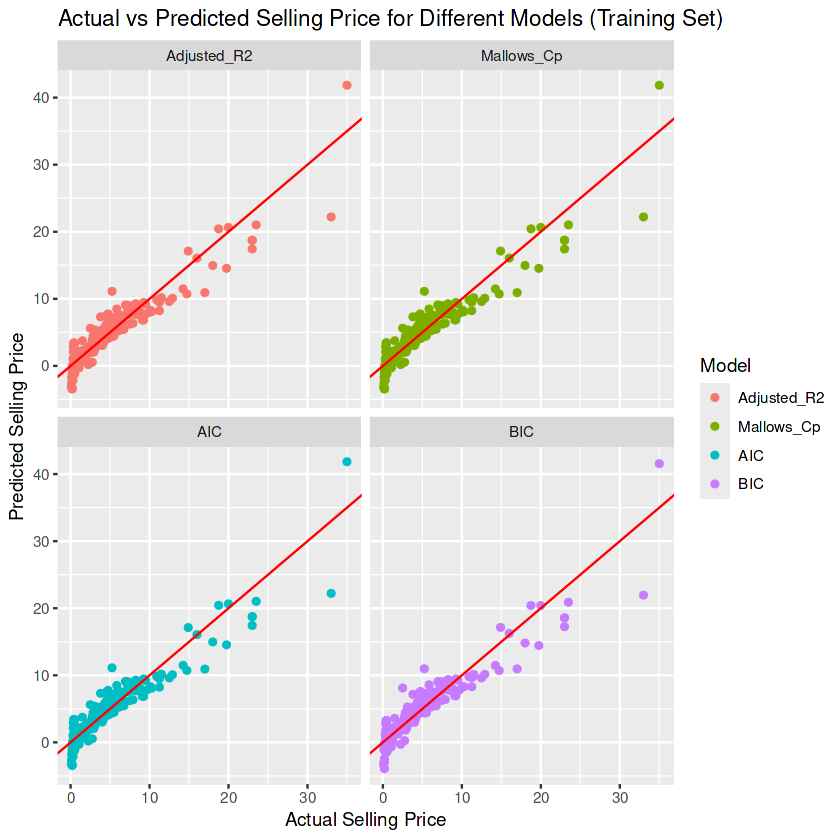

In [ ]:
# Prediction and comparison on training set for each model
models <- list(Adjusted_R2 = model_best_AR, Mallows_Cp = model_best_Cp, AIC = model_best_AIC, BIC = model_best_BIC)
results <- data.frame(Actual = train_data$Selling_Price)

for (model_name in names(models)) {
  model <- models[[model_name]]
  train_data$predicted_Selling_Price <- predict(model, newdata = train_data)
  results[[model_name]] <- train_data$predicted_Selling_Price
}

# Plotting Actual vs Predicted Selling Price for each model on the training set
results_long <- reshape2::melt(results, id.vars = "Actual", variable.name = "Model", value.name = "Predicted")

ggplot(results_long, aes(x = Actual, y = Predicted, color = Model)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, col = "red") +
  facet_wrap(~ Model) +
  ggtitle("Actual vs Predicted Selling Price for Different Models (Training Set)") +
  xlab("Actual Selling Price") +
  ylab("Predicted Selling Price")

# Print correlations for each model on the training set
for (model_name in names(models)) {
  correlation <- cor(results$Actual, results[[model_name]])
  print(paste("Correlation between actual and predicted Selling Price for", model_name, "on the training set:", correlation))
}


# Step 7: Diagnostic Plots and Residual Analysis


	Shapiro-Wilk normality test

data:  residuals(model_best_BIC)
W = 0.89644, p-value = 8.678e-12



Call:
lm(formula = log_Selling_Price ~ Year + Present_Price + Seller_Type + 
    Fuel_Type_Diesel, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.07009 -0.16966  0.00368  0.18502  2.10246 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.351e+02  1.893e+01 -12.422  < 2e-16 ***
Year              1.165e-01  9.400e-03  12.390  < 2e-16 ***
Present_Price     5.129e-02  3.576e-03  14.343  < 2e-16 ***
Seller_Type       1.682e+00  6.396e-02  26.301  < 2e-16 ***
Fuel_Type_Diesel  2.259e-01  7.635e-02   2.959  0.00341 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4084 on 235 degrees of freedom
Multiple R-squared:  0.8951,	Adjusted R-squared:  0.8933 
F-statistic: 501.4 on 4 and 235 DF,  p-value: < 2.2e-16

[1] "Chosen variables for the best BIC model after log transformation:"
[1] "Year"             "Present_Price"    "Seller_Type"      "Fuel_Type_Diesel"


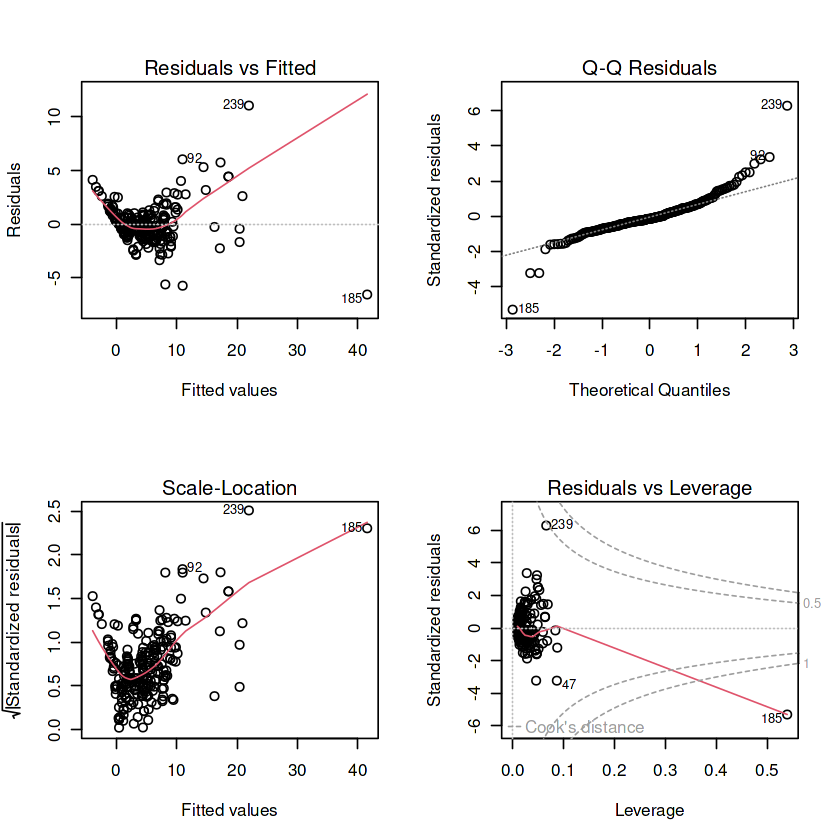

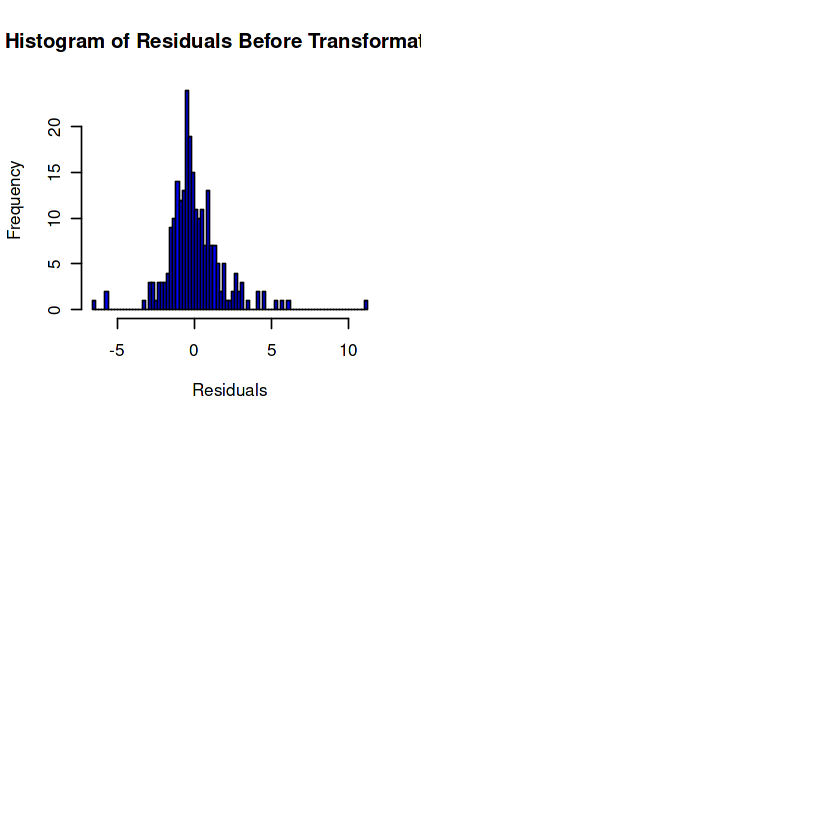


	Shapiro-Wilk normality test

data:  residuals(model_best_BIC_log)
W = 0.92074, p-value = 5.115e-10


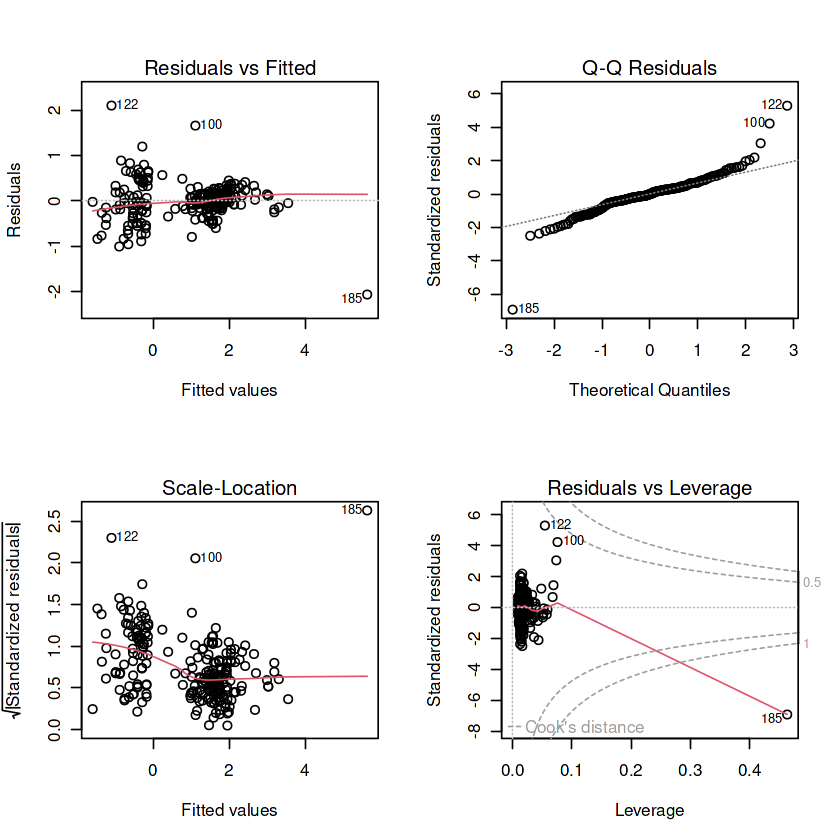

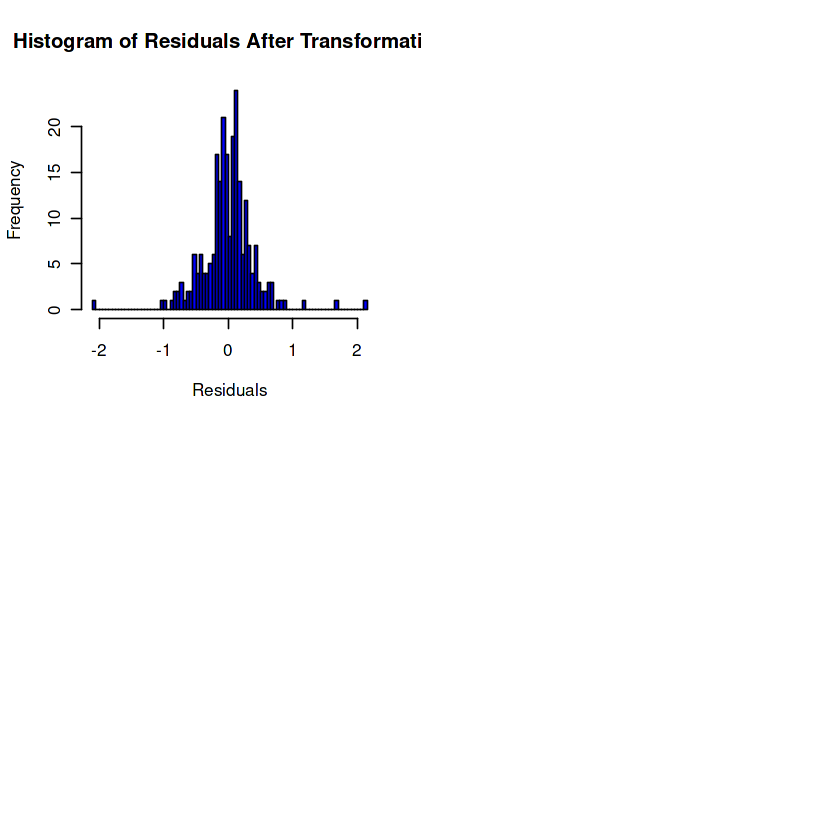

In [ ]:
# Diagnostic Plots for the Best BIC Model
par(mfrow = c(2, 2))
plot(model_best_BIC)
shapiro.test(residuals(model_best_BIC))

# Fit a model with log-transformed Selling_Price
train_data$log_Selling_Price <- log(train_data$Selling_Price)

# Plot histogram of residuals before applying log transformation
hist(model_best_BIC$residuals, breaks=100, main="Histogram of Residuals Before Transformation", xlab="Residuals", col="blue", border="black")

# Model selection using BIC with log transformation
full_model_log <- lm(log_Selling_Price ~ . - Selling_Price, data = train_data)
model_best_BIC_log <- stepAIC(full_model_log, direction = "both", k = log(nrow(train_data)), trace = FALSE)
print(summary(model_best_BIC_log))
print("Chosen variables for the best BIC model after log transformation:")
print(names(coef(model_best_BIC_log))[-1])

par(mfrow = c(2, 2))
plot(model_best_BIC_log)
shapiro.test(residuals(model_best_BIC_log))

# Plot histogram of residuals after log transformation
hist(model_best_BIC_log$residuals, breaks=100, main="Histogram of Residuals After Transformation", xlab="Residuals", col="blue", border="black")


# Step 8: Prediction and Validation on Test Data

,test_data.predicted_Selling_Price,test_data.Selling_Price
,<dbl>,<dbl>
1,5.5549639,4.75
2,7.1746749,7.25
3,7.3206594,6.85
4,2.4681087,2.25
5,4.4526208,3.25
6,1.1228710,6.00
7,0.1771928,0.35
8,5.7848678,5.50
9,3.4914247,2.65


[1] "Correlation between actual and predicted Selling Price for BIC model on validation set: 0.964521788138651"


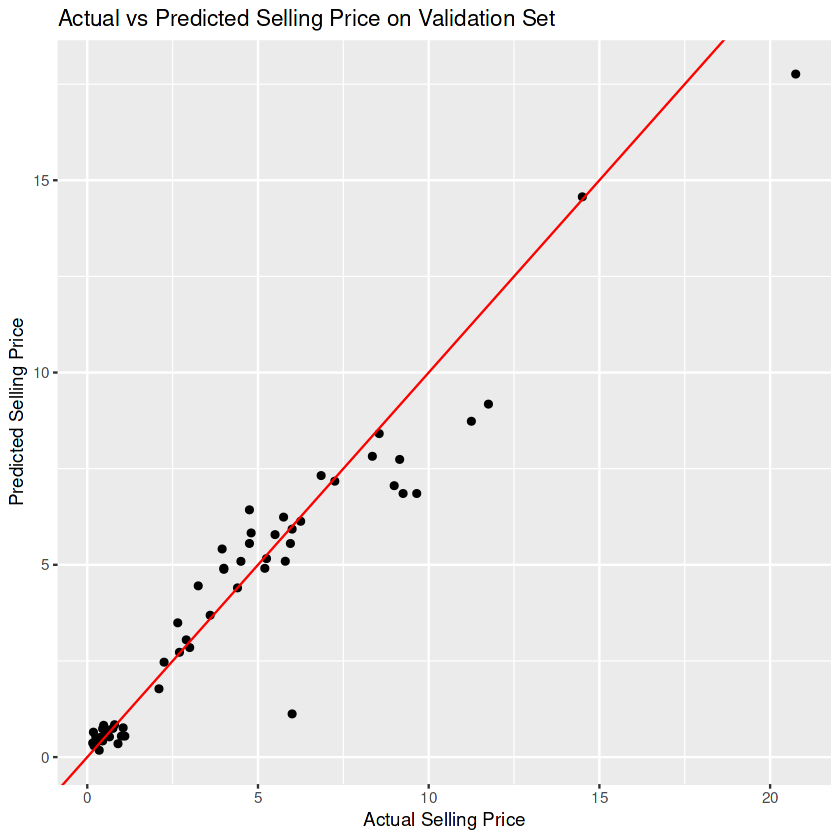

In [ ]:
# Prediction on validation set for the BIC model with log transformation
test_data$predicted_log_Selling_Price <- predict(model_best_BIC_log, newdata = test_data)

# Convert predictions back to the original Selling_Price scale
test_data$predicted_Selling_Price <- exp(test_data$predicted_log_Selling_Price)

p = data.frame(test_data$predicted_Selling_Price, test_data$Selling_Price)
p


# Compare predicted vs actual values
ggplot(test_data, aes(x = Selling_Price, y = predicted_Selling_Price)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, col = "red") +
  ggtitle("Actual vs Predicted Selling Price on Validation Set") +
  xlab("Actual Selling Price") +
  ylab("Predicted Selling Price")

# Print correlation for the BIC model on validation set
correlation <- cor(test_data$Selling_Price, test_data$predicted_Selling_Price)
print(paste("Correlation between actual and predicted Selling Price for BIC model on validation set:", correlation))
